# DataMole Air Pressure Assignment
A customer is manufacturing devices containing air pumps that provide pressure for a machine cycle. Ideally, the air pressure rises sharply and remains stable throughout the machine's cycle, where it drops sharply. However, it can happen that the air pressure drops due to pump failure, or the air pressure rises or drops slowly.

The goal of the project is to detect a pump failure. The typical air pump failure is a temporary pressure decrease in the first half of the cycle.


The Task:
- Develop a predictive model for the PumpFailed column and report its performance in appropriate metrics.
- Explain your model.

Working on air pump failures
- Since we are predicting pump failures this is a classification problem. 
- First lets load and look at the data


In [43]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
raw_data = pd.read_parquet('data/data.parquet')

In [45]:
labels = pd.read_csv('data/labels.csv')

In [46]:
labels.head(10)

,MachineId,MeasurementId,PumpFailed,SlowStart,SlowEnd
0,0_0_0,0,False,False,False
1,0_0_1,-1,NaN,NaN,NaN
2,0_0_2,0,False,False,False
3,0_0_3,0,True,False,False
4,0_1_0,-1,NaN,NaN,NaN
5,0_1_1,1,True,False,False
6,0_1_2,-1,NaN,NaN,NaN
7,0_1_3,-1,NaN,NaN,NaN
8,1_0_0,2,False,True,False
9,1_0_1,-1,NaN,NaN,NaN


In [47]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27385 entries, 0 to 27384
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MachineId      27385 non-null  object
 1   MeasurementId  27385 non-null  int64 
 2   PumpFailed     26900 non-null  object
 3   SlowStart      19300 non-null  object
 4   SlowEnd        19300 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.0+ MB


The labels dataset has 27 385 rows which is relatively big. There are many null values for SlowEnd, SlowStart and PumpFailed. Since the dataset is very big and to save time, we will delete the nan values. However, it is important to note that this may not be the ideal solution as it reduces the dataset size a lot and therefore it may be better to imput the values for SlowStart and SlowEnd, perhaps with modal values. However, more indepth data exploration would be required to ascertain this. 

In [48]:
# Lets merge the machineId and MeasurementId to keep track of the unique cycles
labels['cycle_code'] = labels['MachineId'] + '_' + labels['MeasurementId'].astype(str)

In [49]:
#Now lets delete null values in PumpFailed, SlowStart, and SlowEnd
labels.dropna(subset=['PumpFailed'], inplace = True)
labels.dropna(subset=['SlowStart'], inplace = True)
labels.dropna(subset=['SlowEnd'], inplace = True)
# Convert 'PumpFailed' to integer (0 or 1)
labels['PumpFailed'] = labels['PumpFailed'].astype(int)

In [50]:
labels.head()

,MachineId,MeasurementId,PumpFailed,SlowStart,SlowEnd,cycle_code
0,0_0_0,0,0,False,False,0_0_0_0
2,0_0_2,0,0,False,False,0_0_2_0
3,0_0_3,0,1,False,False,0_0_3_0
5,0_1_1,1,1,False,False,0_1_1_1
8,1_0_0,2,0,True,False,1_0_0_2


In [51]:
#Find the cycle_codes for the non-nan values in Labels so we can delete the corresponding nan values in the raw_data
non_nan_rows = labels['cycle_code']

In [52]:
labels['PumpFailed'].value_counts()

PumpFailed
0    17140
1     2160
Name: count, dtype: int64

The dataset is seriously imbalanced towards the pump not failing which is common in a predictive maintenance datasets. We will have to deal with this later.

Now lets inspect the raw data

In [53]:
raw_data.head()

,MachineId,MeasurementId,Pressure
0,0_0_0,0,0.0
1,0_0_0,0,0.0
2,0_0_0,0,0.0
3,0_0_0,0,0.0
4,0_0_0,0,0.0


In [54]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18466364 entries, 0 to 18466363
Data columns (total 3 columns):
 #   Column         Dtype  
---  ------         -----  
 0   MachineId      object 
 1   MeasurementId  int64  
 2   Pressure       float64
dtypes: float64(1), int64(1), object(1)
memory usage: 422.7+ MB


The dataset is very big with many pressure values. We could consider reducing the data to int32 and float32 values but this could also lead to data loss.

In [55]:
print(f'Machine ID null sum: {raw_data.MachineId.isnull().sum()}')
print(f'Measurement ID null sum: {raw_data.MeasurementId.isnull().sum()}')
print(f'Pressure null sum: {raw_data.Pressure.isnull().sum()}')

Machine ID null sum: 0
Measurement ID null sum: 0
Pressure null sum: 0


In [56]:
raw_data.Pressure.describe()

count    1.846636e+07
mean     3.338926e-01
std      4.862787e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      7.017707e-01
max      6.774464e+00
Name: Pressure, dtype: float64

There are no nan values. It seems like there are many zero values though as the average is 3.34 but the 50% is 0.
First lets make sure that the cycle_codes from labels are matched in the cycle_codes for the raw_data

In [57]:
# First lets merge the machine id and measurement id columns
raw_data['cycle_code'] = raw_data['MachineId'] + '_' + raw_data['MeasurementId'].astype(str)

In [58]:
#Keep only the cycle codes from labels in the raw_data
raw_data_cleaned = raw_data[raw_data['cycle_code'].isin(labels['cycle_code'])]

In [59]:
raw_data_cleaned.MeasurementId.describe()

count    9.608191e+06
mean     4.345681e+03
std      2.537667e+03
min      0.000000e+00
25%      2.336000e+03
50%      4.061000e+03
75%      6.334000e+03
max      8.834000e+03
Name: MeasurementId, dtype: float64

That got rid of many of the zero values.

In [60]:
print((raw_data_cleaned['MeasurementId'] == -1).sum())

0


All of the -1 MeasurementId values were dropped. These must have been a mistake.

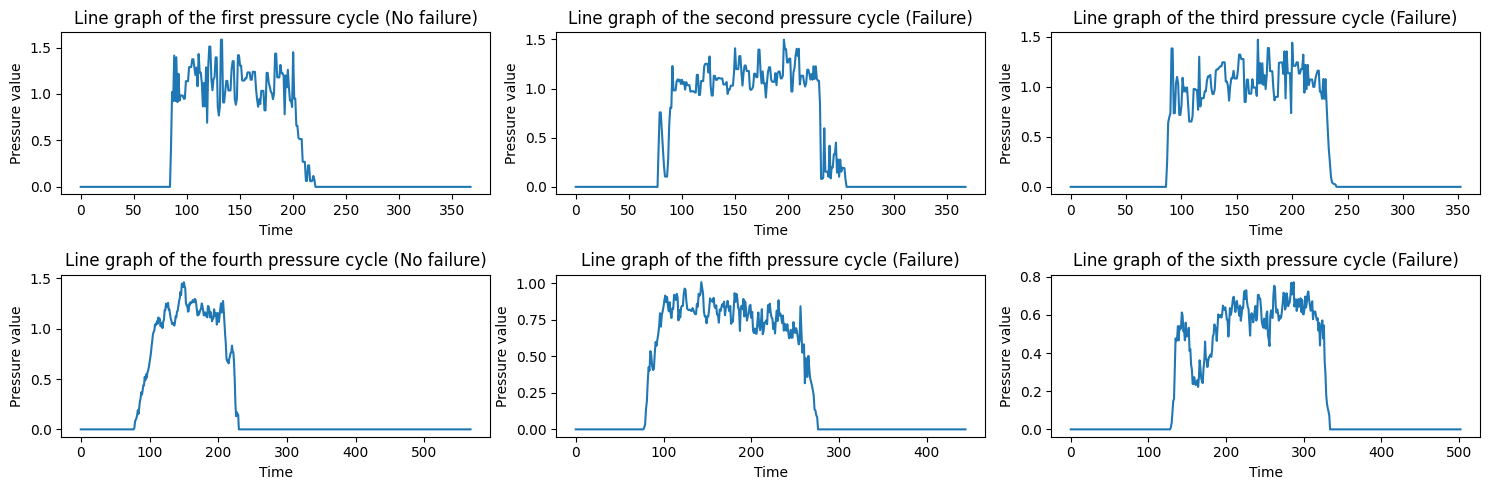

In [61]:
# Now lets plot some of the machine cycles
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 5))

# Plot the first graph
one_cycle = raw_data_cleaned[(raw_data_cleaned['cycle_code'] == '0_0_0_0')]
axes[0, 0].plot(range(len(one_cycle)), one_cycle['Pressure'])
axes[0, 0].set_title('Line graph of the first pressure cycle (No failure)')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Pressure value')

# Access the second subplot
second_cycle = raw_data_cleaned[(raw_data_cleaned['cycle_code'] == '0_0_3_0')]
axes[0, 1].plot(range(len(second_cycle)), second_cycle['Pressure'])
axes[0, 1].set_title('Line graph of the second pressure cycle (Failure)')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Pressure value')

# Access the third subplot
third_cycle = raw_data_cleaned[(raw_data_cleaned['cycle_code'] == '0_1_1_1')]
axes[0, 2].plot(range(len(third_cycle)), third_cycle['Pressure'])
axes[0, 2].set_title('Line graph of the third pressure cycle (Failure)')
axes[0, 2].set_xlabel('Time')
axes[0, 2].set_ylabel('Pressure value')

# Access the fourth subplot
four_cycle = raw_data_cleaned[(raw_data_cleaned['cycle_code'] == '1_0_0_2')]
axes[1, 0].plot(range(len(four_cycle)), four_cycle['Pressure'])
axes[1, 0].set_title('Line graph of the fourth pressure cycle (No failure)')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Pressure value')

# Access the fifth subplot
five_cycle = raw_data_cleaned[(raw_data_cleaned['cycle_code'] == '1_2_2_4')]
axes[1, 1].plot(range(len(five_cycle)), five_cycle['Pressure'])
axes[1, 1].set_title('Line graph of the fifth pressure cycle (Failure)')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Pressure value')

# Access the sixth subplot
six_cycle = raw_data_cleaned[(raw_data_cleaned['cycle_code'] == '2_2_2_3')]
axes[1, 2].plot(range(len(six_cycle)), six_cycle['Pressure'])
axes[1, 2].set_title('Line graph of the sixth pressure cycle (Failure)')
axes[1, 2].set_xlabel('Time')
axes[1, 2].set_ylabel('Pressure value')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

We can see there are many leading and trailing zeros. These could be the machine starting up or just the machine cycle idling. The number of zeros could be a useful indicating of a machine failing but for this assignment we will assume they are the machine waiting to start up and so we will delete them.

In [62]:
#This function finds the index of the non-zero values and then finds the first and last index to split 
# the pressure values
def del_lead_trail_zeros(cycle):
    # Get the indices of non-zero values
    idx_non_zero = cycle.index[cycle['Pressure'] != 0]

    #If the machine cycle has non-zero values:
    if len(idx_non_zero) > 0:
        # Find the first and last non-zero indices
        start = idx_non_zero[0]
        end = idx_non_zero[-1]

        # Slice the DataFrame to keep all values between the first and last non-zero values
        mach_cycle = cycle.loc[start:end + 1]

        return mach_cycle
    else:
        # If there are no non-zero values, return a empty df
        return pd.DataFrame()

In [63]:
#Now lets group the cycle_codes and apply the function. group_keys=False so that the cycle_code is not a new index
data_reduced = raw_data_cleaned.groupby('cycle_code', group_keys=False).apply(del_lead_trail_zeros)

In [64]:
#Check for null values but there shouldnt be any
data_reduced.Pressure.isnull().sum()

0

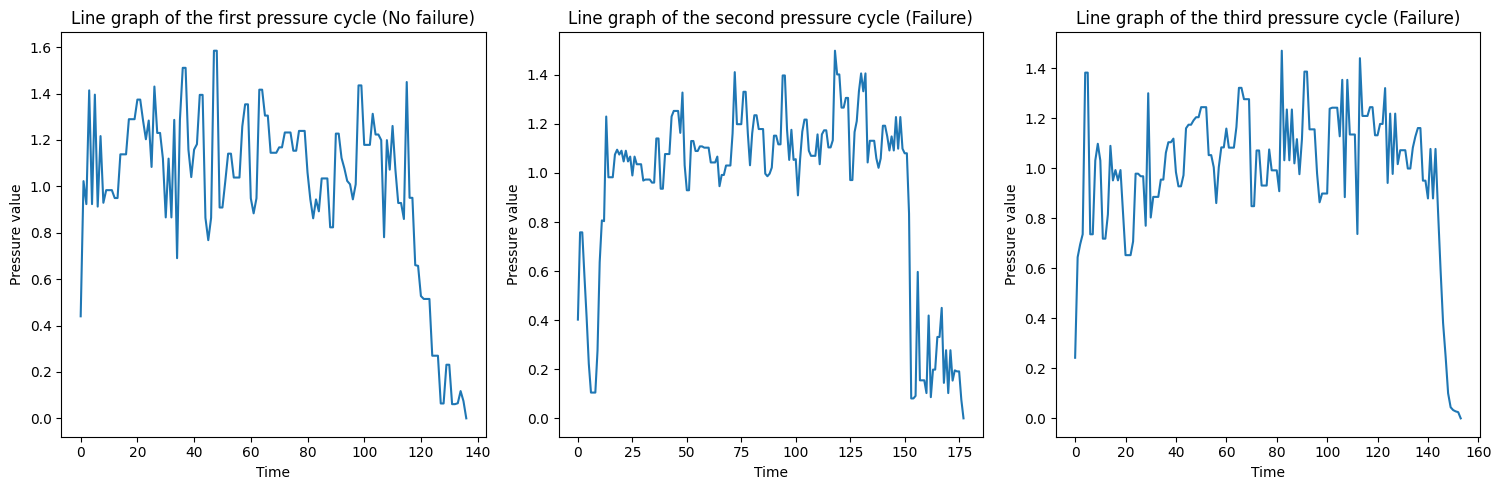

In [65]:
#Now lets plot some graphs to see the result of the del_lead_trail_zeros function
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot the first graph
one_cycle = data_reduced[(data_reduced['cycle_code'] == '0_0_0_0')]
axes[0].plot(range(len(one_cycle)), one_cycle['Pressure'])
axes[0].set_title('Line graph of the first pressure cycle (No failure)')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Pressure value')

second_cycle = data_reduced[(data_reduced['cycle_code'] == '0_0_3_0')]
axes[1].plot(range(len(second_cycle)), second_cycle['Pressure'])
axes[1].set_title('Line graph of the second pressure cycle (Failure)')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Pressure value')

third_cycle = data_reduced[(data_reduced['cycle_code'] == '0_1_1_1')]
axes[2].plot(range(len(third_cycle)), third_cycle['Pressure'])
axes[2].set_title('Line graph of the third pressure cycle (Failure)')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Pressure value')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

That is looking much better, the leading and trialing zeros have been deleted.

# Establish a baseline
- Now lets get a baseline score using the basic Logistic Regression model. This basic model used for binary classification problems. It predicts the probability of a binary outcome.
- Since the dataset is so imbalanced we will ignore the accuracy score and focus on the Recall score (useful when trying to reduce false negatives) and F1 score to assess model performance. 

In [66]:
labels.columns

Index(['MachineId', 'MeasurementId', 'PumpFailed', 'SlowStart', 'SlowEnd',
       'cycle_code'],
      dtype='object')

We will remove the cycle_code, MachineId, and MeasurementId because these can be considered data leakage as the machine cycle codes will not carry as a predictor to other machines and measurement IDs. 

In [67]:
from sklearn.model_selection import train_test_split
X = labels.drop(columns=['PumpFailed', 'cycle_code', 'MachineId', 'MeasurementId'])
y = labels['PumpFailed']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [68]:
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score

def eval_model(model, X_train, X_test, y_train, y_test):
    """
    Evaluate the performance of a classification model.

    Parameters:
    - model: a classifier model
    - X_train, X_test: Testing features
    - y_train, y_test: Target variables

    Returns:
    - recall: Recall score
    - precision: Precision score
    - f1: F1 score
    - auc_roc: AUC-ROC score
    """
    # Fit the model
    model.fit(X_train, y_train)

    # Predict probabilities for positive class
    y_probs = model.predict_proba(X_test)[:, 1]

    # Predict binary outcomes
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_probs)

    print(f"The model used: {model}")
    print(f"Recall: {recall:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"AUC-ROC Score: {auc_roc:.2f}")

    return model, recall, precision, f1, auc_roc

In [69]:
from sklearn.linear_model import LogisticRegression
eval_model(LogisticRegression(), X_train, X_test, y_train, y_test)

The model used: LogisticRegression()
Recall: 0.00
Precision: 0.00
F1 Score: 0.00
AUC-ROC Score: 0.64


c:\Users\mslam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(LogisticRegression(), 0.0, 0.0, 0.0, 0.6402852466682254)

The model fails. So the SlowStart and SlowEnd variables are bad predictors of machine failure and the class imbalance could also be effecting the model performance.

Lets see how many pressure values are measured per cycle, as there could be some 
measurements that carried on for a long time (as in were left running)

# Further exploration of the data

In [70]:
pres_count = data_reduced.groupby('cycle_code')['Pressure'].count().reset_index()
pres_count.columns = ['cycle_code', 'pressure_count']
print(f"The longest cycle length is: {pres_count['pressure_count'].max()}")
print(f"The longest cycle index is: {pres_count['pressure_count'].idxmax()}")

max_pressure_cycle = pres_count.loc[pres_count['pressure_count'].idxmax(), 'cycle_code']

max_pressure_data = data_reduced[data_reduced['cycle_code'] == max_pressure_cycle]

The longest cycle length is: 914
The longest cycle index is: 16508


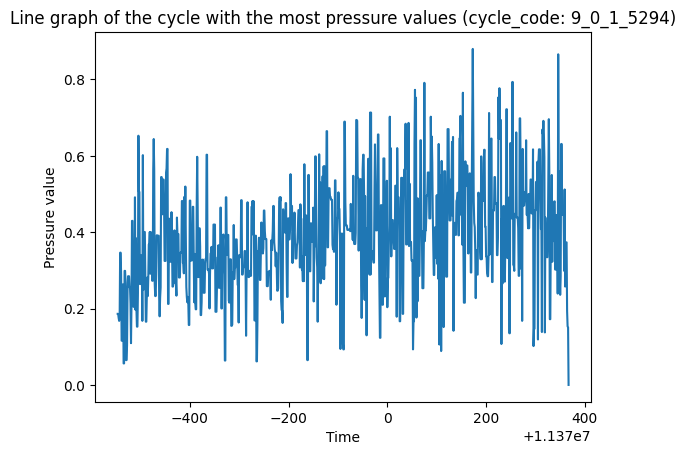

In [71]:
# Plot the longest machine cycle
plt.plot(max_pressure_data.index, max_pressure_data['Pressure'])
plt.title(f'Line graph of the cycle with the most pressure values (cycle_code: {max_pressure_cycle})')
plt.xlabel('Time')
plt.ylabel('Pressure value')
plt.show()

I am not sure if this is a legitimate cycle or not. We could delete it but since we do not know what the machine is producing we will leave it in. This could just be a longer normal machine cycle.

In [72]:
pres_count.describe()

,pressure_count
count,19238.000000
mean,207.606196
std,92.868381
min,2.000000
25%,144.000000
50%,189.000000
75%,250.000000
max,914.000000


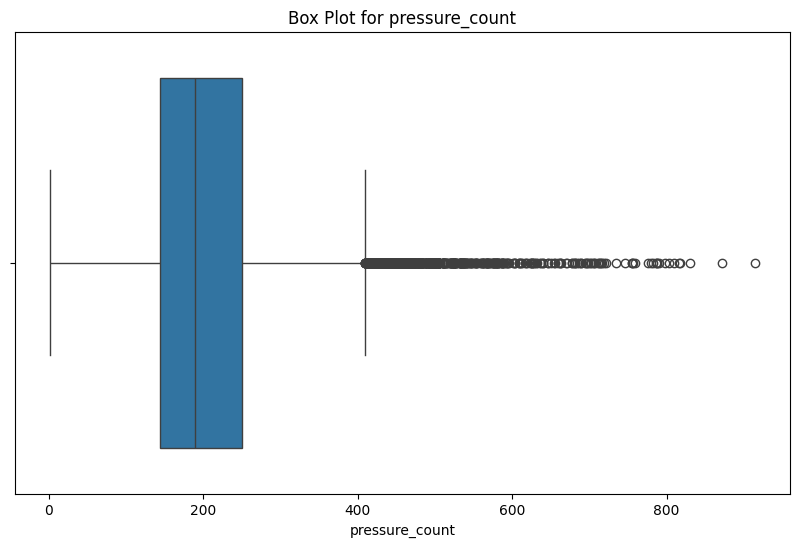

In [73]:
import seaborn as sns
# Plot a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='pressure_count', data=pres_count)
plt.title('Box Plot for pressure_count')
plt.xlabel('pressure_count')
plt.show()

There appear to many outliers on the longer end of the cycle. We would need more time to see if they correlate with any machine Ids (there could be a faulty measuring device). But for now lets use a basic cut off approach and set the threshold to delete all cycle_codes that are shorter than 50 cycles and  longer than 400 measurements.

In [42]:
count = data_reduced.groupby('cycle_code')['Pressure'].count().reset_index()
count.columns = ['cycle_code', 'pressure_count']
filtered_count = count[(count['pressure_count'] >=20)& (count['pressure_count'] <=600)]

selected_cycles = filtered_count['cycle_code']

#Creating a new df without the cycles that are over 500 measurements long.
df_reduced = data_reduced[data_reduced['cycle_code'].isin(selected_cycles)]

#Also delete the rows from the labels df
labels = labels[labels['cycle_code'].isin(selected_cycles)]

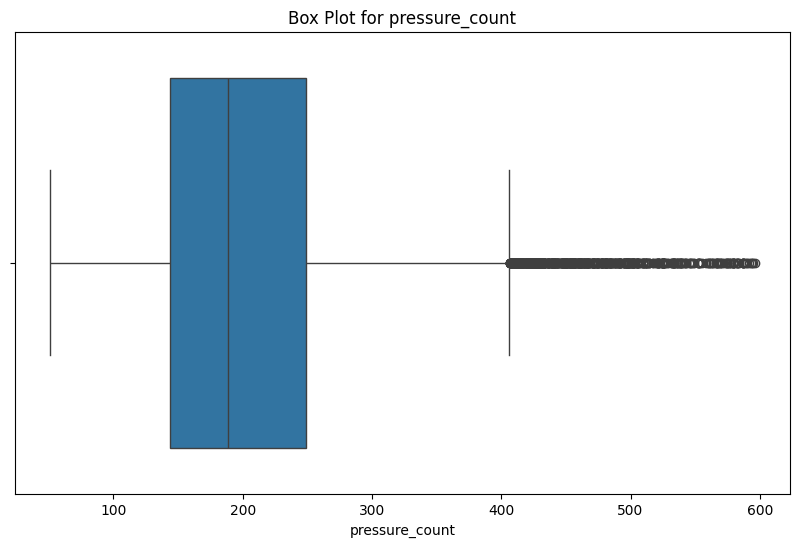

In [77]:
import seaborn as sns
# Plot a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='pressure_count', data=filtered_count)
plt.title('Box Plot for pressure_count')
plt.xlabel('pressure_count')
plt.show()

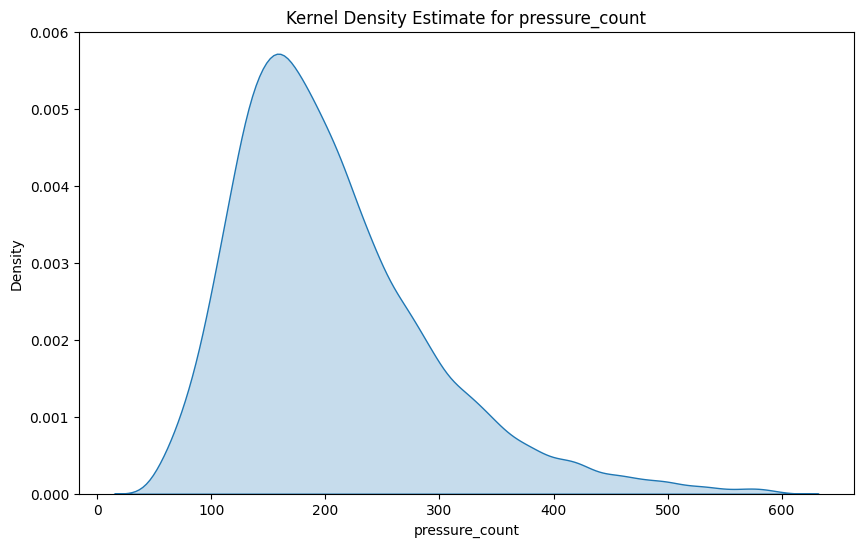

In [78]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=filtered_count, x='pressure_count', fill=True)
plt.title('Kernel Density Estimate for pressure_count')
plt.xlabel('pressure_count')
plt.show()

In [79]:
labels.head()

,MachineId,MeasurementId,PumpFailed,SlowStart,SlowEnd,cycle_code
0,0_0_0,0,0,False,False,0_0_0_0
2,0_0_2,0,0,False,False,0_0_2_0
3,0_0_3,0,1,False,False,0_0_3_0
5,0_1_1,1,1,False,False,0_1_1_1
8,1_0_0,2,0,True,False,1_0_0_2


# Feature Engineering
- Lets engineer some features from the raw data

In [80]:
#now lets work off the first half of the cycle. (This code was made using ChatGPT)
cycle_lengths = data_reduced.groupby('cycle_code')['Pressure'].transform('count')
first_half_index = (cycle_lengths // 2).astype(int)
data_reduced = data_reduced[data_reduced.groupby(['MachineId', 'MeasurementId']).cumcount() < first_half_index]

In [81]:
# Calculate statistics for Pressure grouped by 'cycle_code'
agg_stats = data_reduced.groupby('cycle_code')['Pressure'].agg(['mean', 'std', 'max', 'skew', 'var', 'count']).reset_index()

# Rename columns
agg_stats.columns = ['cycle_code', 'mean_pressure', 'std_pressure', 'max_pressure', 'skewness', 'variance', 'count']

# Merge with the labels DataFrame
labels_eng = pd.merge(labels, agg_stats, on='cycle_code', how='left')
print(labels_eng.isna().sum())

MachineId         0
MeasurementId     0
PumpFailed        0
SlowStart         0
SlowEnd           0
cycle_code        0
mean_pressure    62
std_pressure     66
max_pressure     62
skewness         70
variance         66
count            62
dtype: int64


Not many values are missing so we can delete these. Values with no variance, mean and count could be machine cycles with no measurements.

In [82]:
labels_eng = labels_eng.dropna()
print(labels_eng.isna().sum())

MachineId        0
MeasurementId    0
PumpFailed       0
SlowStart        0
SlowEnd          0
cycle_code       0
mean_pressure    0
std_pressure     0
max_pressure     0
skewness         0
variance         0
count            0
dtype: int64


In [83]:
#Now create a new column called pressure drop which is the difference between each pressure measurement
data_reduced['pressure_drop'] = data_reduced.groupby('cycle_code')['Pressure'].diff()

# Fill NaN values with 0
data_reduced['pressure_drop'].fillna(0, inplace=True)

In [84]:
#The size of the first presure drop
def calculate_total_first_drop(df):
    total_drop = 0
    in_drop = False

    for pressure_drop in df['pressure_drop']:
        if pressure_drop < 0:
            in_drop = True
            total_drop += pressure_drop
        elif in_drop:
            break

    return total_drop

# Apply the function to each cycle
result_total_drop = data_reduced.groupby('cycle_code').apply(calculate_total_first_drop).reset_index()
result_total_drop.columns = ['cycle_code', 'Total_First_Drop']
labels_eng = pd.merge(labels_eng, result_total_drop, on='cycle_code', how='left')

In [85]:
#Kurtosis - measures outliers
kurt_vals = data_reduced.groupby('cycle_code')['Pressure'].apply(lambda x: x.kurtosis()).reset_index()
kurt_vals.columns = ['cycle_code', 'kurtosis']
labels_eng = pd.merge(labels_eng, kurt_vals, on='cycle_code', how='left')

In [86]:
labels_eng.head()

,MachineId,MeasurementId,PumpFailed,SlowStart,SlowEnd,cycle_code,mean_pressure,std_pressure,max_pressure,skewness,variance,count,Total_First_Drop,kurtosis
0,0_0_0,0,0,False,False,0_0_0_0,1.141348,0.225699,1.584466,-0.292531,0.050940,68.0,-0.099029,0.128916
1,0_0_2,0,0,False,False,0_0_2_0,0.817599,0.161863,1.205104,0.164595,0.026200,100.0,-0.215501,0.239542
2,0_0_3,0,1,False,False,0_0_3_0,0.997734,0.265797,1.410603,-1.973220,0.070648,89.0,-0.652807,4.069965
3,0_1_1,1,1,False,False,0_1_1_1,0.995153,0.207449,1.382474,-0.589658,0.043035,77.0,-0.646392,1.052072
4,1_0_0,2,0,True,False,1_0_0_2,0.896080,0.402125,1.462193,-0.715398,0.161705,76.0,-0.036862,-0.688276


In [87]:
labels_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19230 entries, 0 to 19229
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MachineId         19230 non-null  object 
 1   MeasurementId     19230 non-null  int64  
 2   PumpFailed        19230 non-null  int32  
 3   SlowStart         19230 non-null  object 
 4   SlowEnd           19230 non-null  object 
 5   cycle_code        19230 non-null  object 
 6   mean_pressure     19230 non-null  float64
 7   std_pressure      19230 non-null  float64
 8   max_pressure      19230 non-null  float64
 9   skewness          19230 non-null  float64
 10  variance          19230 non-null  float64
 11  count             19230 non-null  float64
 12  Total_First_Drop  19230 non-null  float64
 13  kurtosis          19229 non-null  float64
dtypes: float64(8), int32(1), int64(1), object(4)
memory usage: 2.0+ MB


In [ ]:
labels_eng = labels_eng.dropna()
print(labels_eng.isna().sum())

In [88]:
labels_eng.columns

Index(['MachineId', 'MeasurementId', 'PumpFailed', 'SlowStart', 'SlowEnd',
       'cycle_code', 'mean_pressure', 'std_pressure', 'max_pressure',
       'skewness', 'variance', 'count', 'Total_First_Drop', 'kurtosis'],
      dtype='object')

Now lets test how well these engineered features predict the pump failure. First since the dataset is unbalanced we will apply the SMOTETomek which is applies SMOTE to oversample the minority class and then Tomek to remove instances of of the classes invovled in the links.

In [90]:
from imblearn.combine import SMOTETomek

In [91]:

st = SMOTETomek()
X_resampled, y_resampled = st.fit_resample(labels_eng.drop(columns=['PumpFailed', 'MeasurementId', 'MachineId', 'cycle_code']),
                                labels_eng['PumpFailed'])

X_train, X_test, y_train, y_test = train_test_split(X_resampled,y_resampled, random_state = 1)

ValueError: Input X contains NaN.
SMOTETomek does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [39]:
X_test

,SlowStart,SlowEnd,mean_pressure,std_pressure,max_pressure,skewness,variance,count,Total_First_Drop,kurtosis
27936,0.0,0.0,1.303552,0.252804,1.663148,-2.281407,0.064047,65.084593,-0.248996,9.366183
15530,0.0,0.0,1.094049,0.201530,1.347378,-3.730771,0.040614,99.000000,-0.044007,16.650332
23528,0.0,0.0,0.851561,0.207338,1.201247,-1.828253,0.043035,104.000000,-0.072590,4.622312
9757,0.0,0.0,0.981484,0.280244,1.473415,-0.688200,0.078537,55.000000,-0.061350,1.270929
2958,0.0,0.0,1.021116,0.097750,1.340741,1.047134,0.009555,111.000000,-0.081481,1.370456
...,...,...,...,...,...,...,...,...,...,...
7504,0.0,0.0,1.238453,0.246222,1.521173,-2.875866,0.060625,122.000000,-0.016287,10.339497
16892,0.0,0.0,1.195697,0.268358,1.541463,-1.361371,0.072016,73.000000,-0.146341,3.186297
8623,0.0,0.0,1.052011,0.210707,1.521288,-0.022042,0.044398,115.000000,-0.789200,0.328853
23198,0.0,0.0,1.119155,0.196235,1.810519,0.438802,0.038508,85.663680,-0.363839,3.582251


Now we will standardise the float features. We will chose between the two basic standard scaler or min max scaler. Standard scaler works well for normally distributed data. Lets look at the

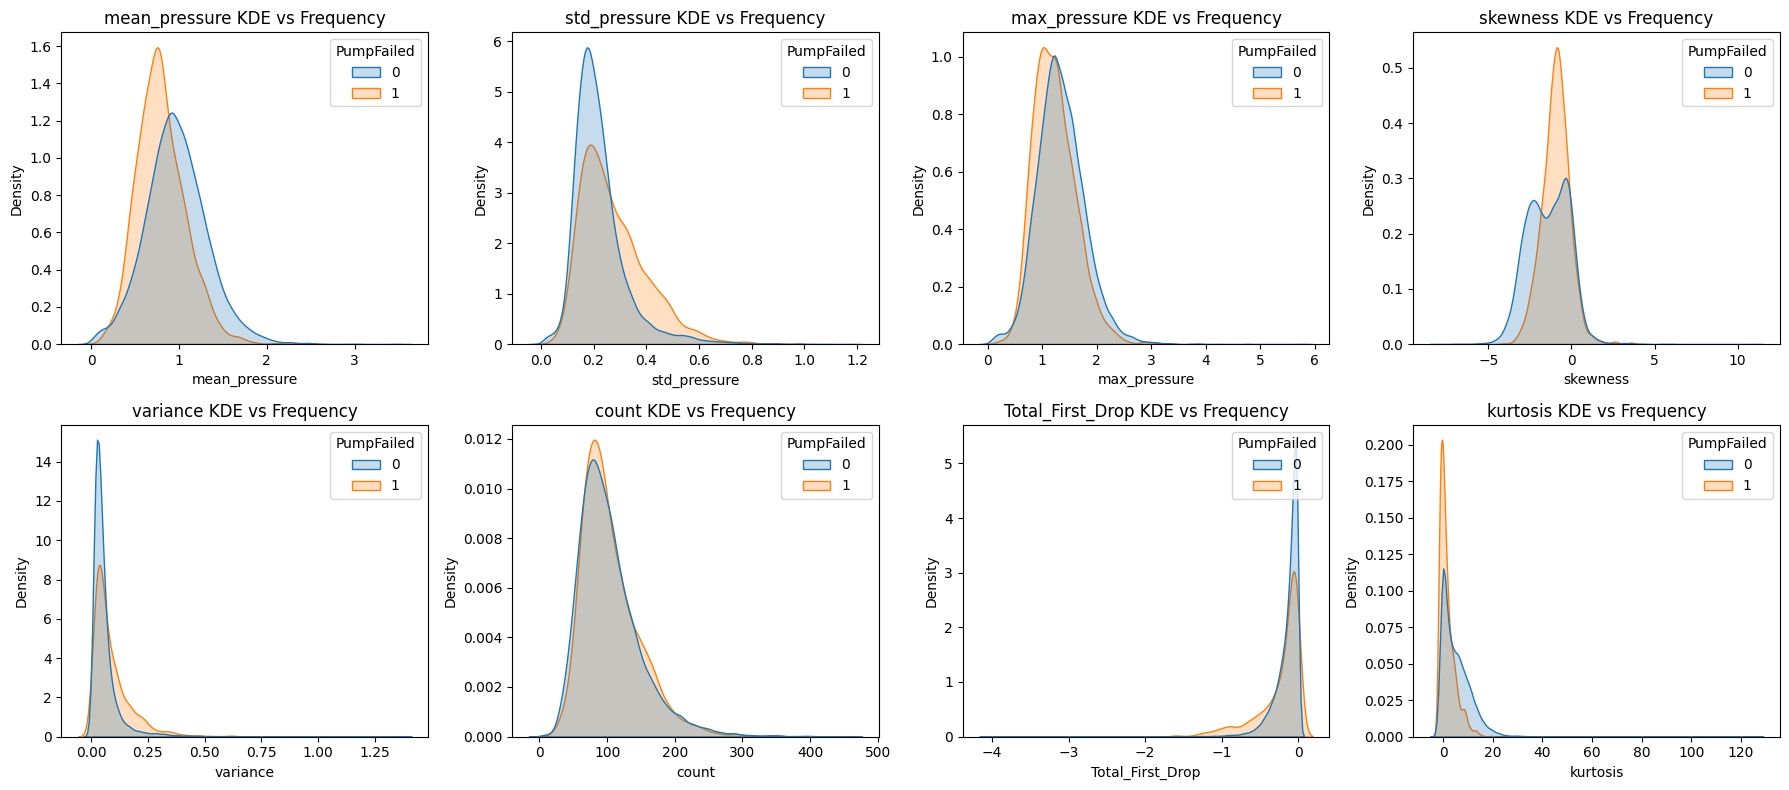

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of features
x_values = ['mean_pressure', 'std_pressure', 'max_pressure',
       'skewness', 'variance', 'count', 'Total_First_Drop', 'kurtosis']

# Set up the subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 8))

# Plot KDE against Frequency for each feature
for i, feature in enumerate(x_values):
    row_index = i // 4
    col_index = i % 4
    sns.kdeplot(data=labels_eng, x=feature, hue='PumpFailed', fill=True, common_norm=False, ax=axes[row_index, col_index])
    axes[row_index, col_index].set_title(f'{feature} KDE vs Frequency')

# Adjust layout
plt.tight_layout()
plt.show()


The variance, skewness, total_first_drop and kurtosis are not normally distributed so we will use the Min Max Scaler. We will also use a distance based model (KNN) so min max will work well with this model. It is important to use the scaler after the train test split to avoid data leakage. However, after testing using the standard scaler and min max scaler, all three models performed better without scaling the data. There are more complex scalers to use such as the Robust Scaler to deal with outliers but for this exercise we wont use a scaler to save time.

In [94]:
# #We are not going to apply the standard scaler
# from sklearn.preprocessing import RobustScaler
# # Standardize your features
# scale_columns = ['mean_pressure', 'std_pressure', 'max_pressure',
#        'skewness', 'variance', 'count', 'Total_First_Drop', 'kurtosis']
# scaler = RobustScaler()
# X_train = scaler.fit_transform(X_train[scale_columns])
# X_test = scaler.transform(X_test[scale_columns])

In [41]:
from sklearn.linear_model import LogisticRegression
model, recall, precision, f1, auc_roc = eval_model(LogisticRegression(max_iter = 1000), X_train, X_test, y_train, y_test)
print(f"The model used: {model}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC Score: {auc_roc:.4f}")

The model used: LogisticRegression(max_iter=1000)
Recall: 0.8490
Precision: 0.7928
F1 Score: 0.8200
AUC-ROC Score: 0.8936


c:\Users\mslam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [42]:
from sklearn.ensemble import RandomForestClassifier
model, recall, precision, f1, auc_roc = eval_model(RandomForestClassifier(random_state=1), X_train, X_test, y_train, y_test)
print(f"The model used: {model}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC Score: {auc_roc:.4f}")

The model used: RandomForestClassifier(random_state=1)
Recall: 0.9256
Precision: 0.9012
F1 Score: 0.9132
AUC-ROC Score: 0.9739


In [43]:
from sklearn.neighbors import KNeighborsClassifier
model, recall, precision, f1, auc_roc = eval_model(KNeighborsClassifier(), X_train, X_test, y_train, y_test)
print(f"The model used: {model}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC Score: {auc_roc:.4f}")

The model used: KNeighborsClassifier()
Recall: 0.9600
Precision: 0.7887
F1 Score: 0.8660
AUC-ROC Score: 0.9345


So the RandomForest model performs the best with the highest recall, precision, and AUC_ROC.

In [44]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)

X = labels_eng.drop(columns=['PumpFailed', 'MeasurementId', 'MachineId', 'cycle_code'])
y = labels_eng['PumpFailed']
clf.fit(X, y)

# Get feature importances
feature_importances = clf.feature_importances_

# Create a DataFrame to display the feature importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the top features
print(importance_df)

            Feature  Importance
9          kurtosis    0.131014
5          skewness    0.124121
2     mean_pressure    0.122630
6          variance    0.110409
3      std_pressure    0.109044
8  Total_First_Drop    0.105774
4      max_pressure    0.104998
7             count    0.087242
1           SlowEnd    0.055388
0         SlowStart    0.049380


In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score

In [73]:


# Define the parameter grid for GridSearchCV
param_grid = {'n_estimators': [100,250, 500],
              'max_features': ['auto', 'sqrt'],
              'max_depth': [None, 5, 10, 20]
}

# Create RandomForestClassifier
rf = RandomForestClassifier()

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=3,
                           scoring='recall',
                           verbose=1)

# Fit the model to the data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_rf = grid_search.best_estimator_

# Make predictions using the best model
pred_best_rf = best_rf.predict(X_test)

# Print classification report and accuracy
print(classification_report(y_test, pred_best_rf))
print(f"Random Forest F1 score: {f1_score(y_test, pred_best_rf) * 100}%")


Fitting 3 folds for each of 24 candidates, totalling 72 fits


c:\Users\mslam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning: 
36 fits failed out of a total of 72.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\mslam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\mslam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1344, in wrapper
    estimator._validate_params()
  File "c:\Users\mslam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py

Best Hyperparameters: {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 250}
              precision    recall  f1-score   support

           0       0.92      0.89      0.91      4074
           1       0.89      0.92      0.91      3979

    accuracy                           0.91      8053
   macro avg       0.91      0.91      0.91      8053
weighted avg       0.91      0.91      0.91      8053

Random Forest F1 score: 90.68415192379067%


In [47]:
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.metrics import accuracy_score, roc_curve,confusion_matrix
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve

In [51]:
def score_model(model, X_train, X_test, y_train, y_test):
    '''
    Split the data, train the model specified and return score metrics

    Parameters:
    - X_test, X_train: features from the dataset
    - y_train, y_test: PumpFailed target variable

    Returns:
    - accuracy, precision,
     recall, F1, classification_report, roc_auc, cross_val_accuracy, cross_val_roc_auc
    - plots AUC_ROC Curve, Precision_Recall Curve
    '''
    
   
    #Train model
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    # Performance scores
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    classification_rep = classification_report(y_test, y_pred, zero_division=0)

    # Cross-val scores
    cv_score_all = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    cv_score = np.mean(cv_score_all)
    cv_roc_auc_all = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
    cv_roc_auc = np.mean(cv_roc_auc_all)

    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall score: {recall}')
    print(f'F1 score: {f1}')
    print(f'Classification report: {classification_rep}')
    print(f'ROC_AUC score: {roc_auc}')
    print(f'Cross-validation score: {cv_score}')
    print(f'Cross-validation ROC AUC score: {cv_roc_auc}')

    #Plotting the AUC-ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    plt.title('ROC Curve')
    plt.show()

    #Plotting Precision_Recall
    prec, recall, _ = precision_recall_curve(y_test, y_proba)
    PrecisionRecallDisplay(precision = prec, recall = recall).plot()
    plt.title('Precision-Recall Curve')
    plt.show()

    #Confusion matrix
    cm = confusion_matrix(y_test, y_pred,)
    sns.heatmap(cm, annot=True, fmt=',', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, precision, f1, roc_auc, classification_rep, cv_score, cv_roc_auc

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.9118627918056217
Precision: 0.9012835472578763
Recall score: 0.9241445321847331
F1 score: 0.9125708884688091
Classification report:               precision    recall  f1-score   support

           0       0.92      0.90      0.91      4217
           1       0.90      0.92      0.91      4179

    accuracy                           0.91      8396
   macro avg       0.91      0.91      0.91      8396
weighted avg       0.91      0.91      0.91      8396

ROC_AUC score: 0.9741168039685765
Cross-validation score: 0.9201212885966674
Cross-validation ROC AUC score: 0.8804624217619198


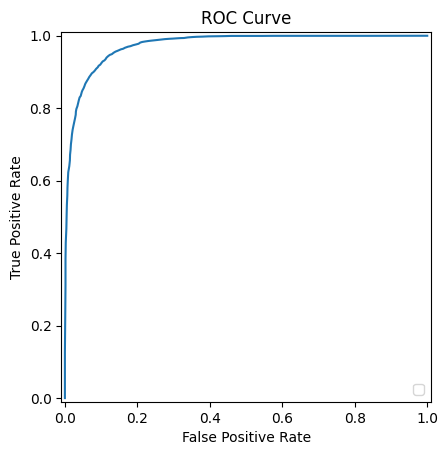

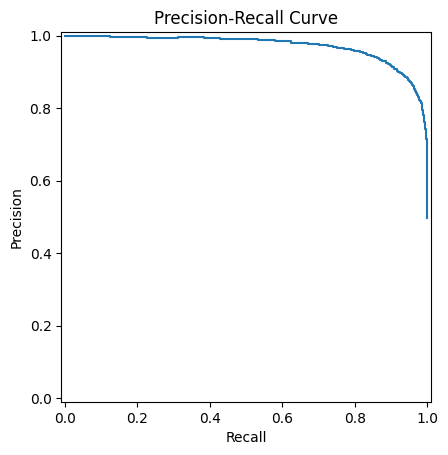

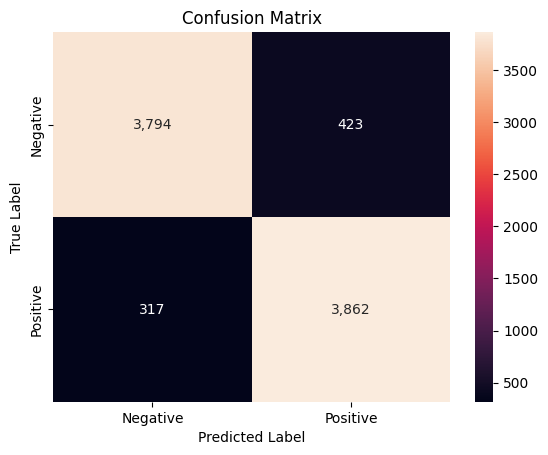

(0.9118627918056217,
 0.9012835472578763,
 0.9125708884688091,
 0.9741168039685765,
 '              precision    recall  f1-score   support\n\n           0       0.92      0.90      0.91      4217\n           1       0.90      0.92      0.91      4179\n\n    accuracy                           0.91      8396\n   macro avg       0.91      0.91      0.91      8396\nweighted avg       0.91      0.91      0.91      8396\n',
 0.9201212885966674,
 0.8804624217619198)

In [52]:
score_model(RandomForestClassifier(), X_train, X_test, y_train, y_test)